In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
# from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/all')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7
ROAD_LINES=6

In [7]:
S_PREFIX = '12-dl'

In [8]:
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TTF

### Create dataloader

In [9]:
class MatchedFilesDataset(Dataset):
    def __init__(self, fnames, y, tfms, path):
        self.path,self.fnames = path,fnames
        self.open_fn = pil_loader
        self.y=y
        self.open_y_fn = pil_loader
        assert(len(fnames)==len(y))
        
        self.n = self.get_n()
        self.c = self.get_c()
        self.tfms = tfms
#         self.sz = self.get_sz()
        
#     def get_sz(self): return self.transform.sz
    def get_x(self, i): return self.open_fn(os.path.join(self.path, self.fnames[i]))
    def get_y(self, i): return self.open_y_fn(os.path.join(self.path, self.y[i]))
    def get_n(self): return len(self.fnames)
    def get_c(self): return 2
    
    def get(self, tfms, x, y):
        for fn in tfms:
            #pdb.set_trace()
            x, y = fn(x, y)
        return (x, y)
    
    def __getitem__(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.tfms, x, y)
    
    def __len__(self): return self.n

    def resize_imgs(self, targ, new_path):
        dest = resize_imgs(self.fnames, targ, self.path, new_path)
        return self.__class__(self.fnames, self.y, self.transform, dest)

In [10]:

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)
    
    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [11]:
def crop_bg_pil(x,y):
    w, h = x.size
    top = int(h/3.75)
    bot = int(h*.9 + h/150)
    pad_right=32-w%32
    return TTF.crop(x, top, 0, bot-top, w+pad_right), TTF.crop(y, top, 0, bot-top, w+pad_right)

In [12]:
class RHF(object):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x, y):
        if random.random() < self.p:
            return TTF.hflip(x), TTF.hflip(y)
        return x,y

In [13]:
class RR(object):
    def __init__(self, degrees=2): self.degrees = degrees
    def __call__(self, x, y):
        angle = random.uniform(-self.degrees, self.degrees)
        return TTF.rotate(x, angle), TTF.rotate(y, angle)

In [14]:
def tfm_x_wrapper(tfm):
    return lambda x,y: (tfm(x), y)

In [15]:
class RC():
    def __init__(self, targ_sz):
        self.targ_sz = targ_sz

    def __call__(self, x, y):
        rand_w = random.uniform(0, 1)
        rand_h = random.uniform(0, 1)
        w,h = x.size
        t_w,t_h = self.targ_sz
        start_x = np.floor(rand_w*(w-t_w)).astype(int)
        start_y = np.floor(rand_h*(h-t_h)).astype(int)
        return TTF.crop(x, start_y, start_x, t_h, t_w), TTF.crop(y, start_y, start_x, t_h, t_w)

In [16]:
x_names_val = np.array(glob(str(PATH/'AnswersRGB'/'*.png')))
y_names_val = np.array(glob(str(PATH/'AnswersSeg'/'*.png')))

In [17]:
def convert_y(y_img):
    y_new = np.zeros(y_img.shape, dtype=int)
    y_new[y_img==VEHICLES] = 1
    cutoff_y = int(y_new.shape[0]*.83)
    y_new[cutoff_y:,:] = 0

    y_new[y_img==ROADS] = 2
    y_new[y_img==ROAD_LINES] = 2
    return torch.from_numpy(y_new).long()

def xy_tensor(x,y):
    y_img = np.array(y, np.int32, copy=False)
    return TTF.to_tensor(x), convert_y(y_img[:,:,0])

In [18]:
def torch_loader(f_ext, data_path, bs, size, workers=7):
    # Data loading code
    x_names = np.array(glob(str(data_path/f'CameraRGB{f_ext}'/'*.png')))
    y_names = np.array(glob(str(data_path/f'CameraSeg{f_ext}'/'*.png')))
    x_names_val = np.array(glob(str(data_path/f'AnswersRGB{f_ext}'/'*.png')))
    y_names_val = np.array(glob(str(data_path/f'AnswersSeg{f_ext}'/'*.png')))
    val_idxs = list(range(100))
    val_x,val_y = x_names_val, y_names_val
    trn_x,trn_y = x_names, y_names
    
    normalize = transforms.Normalize(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])
    
    train_tfms = [
        crop_bg_pil,
        tfm_x_wrapper(transforms.ColorJitter(.2,.2,.2)),
#         tfm_x_wrapper(Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec'])),
        RR(),
        RHF(),
#         RC((96,96)),
        xy_tensor,
        tfm_x_wrapper(normalize),
    ]
    train_dataset = MatchedFilesDataset(trn_x, trn_y, train_tfms, path='')
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_tfms = [
        crop_bg_pil,
        xy_tensor,
        tfm_x_wrapper(normalize)
    ]
    val_dataset = MatchedFilesDataset(val_x, val_y, val_tfms, path='')
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    train_loader = DataPrefetcher(train_loader)
    val_loader = DataPrefetcher(val_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    return data


In [19]:
def denorm(x):
    x_np = x.cpu().numpy()
    x_np = np.rollaxis(x_np, 0, 3)
    mean=np.array([0.4914 , 0.48216, 0.44653])
    std=np.array([0.24703, 0.24349, 0.26159])
    x_np = x_np*std+mean
    return x_np

In [20]:
sz = 96
bs = 2
data = torch_loader('-150', PATH, bs, sz)

In [21]:
x,y = data.trn_ds[0]

In [22]:
x.shape, y.float().mean()

(torch.Size([3, 96, 224]), 0.5579892113095238)

In [23]:
x_out = denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


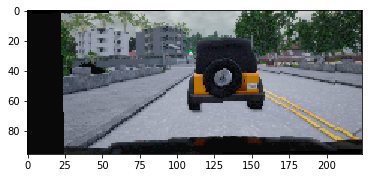

In [24]:
plt.imshow(x_out)

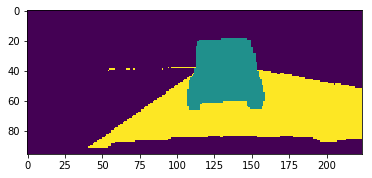

In [25]:
plt.imshow(y)

In [26]:
def new_acc(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## Simple upsample

In [27]:
f = resnet34
cut,lr_cut = model_meta[f]

In [28]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

## U-net (ish)

In [29]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [30]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p, inplace=True))

In [31]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x), inplace=True)
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [32]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        if isinstance(self.model, FP16):
            model = self.model.module
        else:
            model = self.model
        lgs = list(split_by_idxs(children(model.rn), [lr_cut]))
#         print('LGS:', lgs)
#         print('Add:', children(model)[1:])
        return lgs + [children(model)[1:]]

In [33]:
def get_learner(md):
    m_base = get_base()
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.CrossEntropyLoss()
#     learn.crit = nn.BCEWithLogitsLoss()
    learn.metrics=[new_acc]
    return learn

In [34]:
ext = '-150'
sz = 96
bs = 64
md = torch_loader('-150', PATH, bs, sz)

In [35]:
learn = get_learner(md)

In [36]:
# learn.half()

In [37]:
x,y = next(iter(md.trn_dl))

In [38]:
learn.freeze_to(1)

### Loading from train6 model

In [39]:
learn.load('600urn-pad-instead')

In [ ]:
learn.lr_find()
learn.sched.plot()

In [44]:
lr=1e-1
# lr=4e-3
wd=1e-5

lrs = np.array([lr/200,lr/20,lr])/2

In [ ]:
learn.fit(lr,1,wds=wd,cycle_len=15,use_clr=(5,8))

In [ ]:
learn.save(f'128urn-{S_PREFIX}-tmp')

In [45]:
learn.load(f'128urn-{S_PREFIX}-tmp')

In [46]:
learn.unfreeze()
learn.bn_freeze(True)

In [47]:
learn.fit(lrs/3, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc                    
    0      0.020588   0.046489   0.987474  
    1      0.019032   0.052715   0.986327                   
    2      0.018694   0.044482   0.988526                   
    3      0.017662   0.041987   0.989173                   
    4      0.016893   0.04623    0.988401                   
    5      0.016045   0.044727   0.989078                   
    6      0.015545   0.046052   0.988908                   
    7      0.014994   0.044504   0.989255                   
    8      0.014695   0.043487   0.989455                   
    9      0.014349   0.043375   0.989597                   



[array([0.04337]), 0.9895972609519958]

In [ ]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

In [48]:
learn.save(f'128urn-{S_PREFIX}-0')

In [ ]:
learn.load(f'128urn-{S_PREFIX}-0')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
py = np.argmax(py,1)

In [ ]:
show_img(md.trn_ds.denorm(x)[0])

In [ ]:
show_img(py[0]);

In [ ]:
show_img(y[0]);

## 256x256

In [49]:
sz=192
bs=64

In [51]:
ext = '-300'
sz=192
bs=64
md = torch_loader(ext, PATH, bs, sz)

In [1]:
lr=1e-1
wd=1e-5

lrs = np.array([lr/200,lr/20,lr])/2

NameError: name 'np' is not defined

In [ ]:
learn = get_learner(md)

In [ ]:
learn.freeze_to(1)

In [55]:
learn.load(f'128urn-{S_PREFIX}-0')

In [56]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   new_acc                    
    0      0.034208   273.687256 0.36713   
    1      0.045339   0.069043   0.978314                   
    2      0.069297   0.129782   0.967486                   
    3      0.044004   0.085791   0.975774                   
    4      0.045727   0.131251   0.957123                   
 71%|███████   | 51/72 [00:30<00:12,  1.65it/s, loss=0.0368]

Process Process-230:
Process Process-229:
Process Process-228:
Process Process-231:
Traceback (most recent call last):
Process Process-226:
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-225:
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-227:
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/lyft/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/p

In [ ]:
learn.save(f'256urn-{S_PREFIX}-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.load(f'256urn-{S_PREFIX}-tmp')

In [ ]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

In [ ]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

In [ ]:
learn.save(f'256urn-{S_PREFIX}')

In [ ]:
learn.load(f'256urn-{S_PREFIX}')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
py = np.argmax(py,1)

In [ ]:
show_img(py[0]);

In [ ]:
show_img(y[0]);

In [ ]:
m.close()

## 512x512

In [ ]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
sz=288
bs=16

In [ ]:
md = get_data('', bs, sz)

In [ ]:
learn = get_learner(md)

In [ ]:
learn.load(f'256urn-{S_PREFIX}')

In [ ]:
learn.freeze_to(1)

In [ ]:
lr=4e-2
wd=1e-5

lrs = np.array([lr/200,lr/20,lr])/2

In [ ]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(5,4))

In [ ]:
learn.save(f'600urn-{S_PREFIX}-tmp')

In [ ]:
learn.load(f'600urn-{S_PREFIX}-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/200,lr/30,lr])

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save(f'600urn-{S_PREFIX}')

In [ ]:
learn.load(f'600urn-{S_PREFIX}')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
show_img(py[0]>0);

In [ ]:
show_img(y[0]);

## Save results

In [ ]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))

In [ ]:
# model_summary(m, [3,608,800])

In [ ]:
# learn.load('1024urn')
load_model(m, str(PATH/f'models/600urn-{S_PREFIX}.h5'))

In [ ]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
    print("Error loading video")
    quit

# Define encoder function
def encode(array):
    pil_img = Image.fromarray(array)
    buff = BytesIO()
    pil_img.save(buff, format="PNG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)

In [ ]:
# resized_video = np.array([scipy.misc.imresize(f, size=(512,512)) for f in video])

In [ ]:
def normalize(x):
    if np.mean(x) > 1:
        x = x/255
    m,s = imagenet_stats
    x = (x-m)/s
    return x
def preprocess(video):
    f1_norm = normalize(video)
    f1_roll = np.rollaxis(f1_norm, 3, 1)
    f1_pad = np.pad(f1_roll, [(0,0),(0,0),(0,8),(0,0)], mode='constant')
    return f1_pad

In [ ]:
f1 = preprocess(video)

In [ ]:
results = []
for i in range(0,f1.shape[0],8):
    xv = VV(torch.from_numpy(f1[i:i+8]).contiguous().float())
    preds = m(xv)
    mx,idx = torch.max(preds, 1)
    idx_slice = idx[:,:-8,:]
    results.append(idx_slice)

In [ ]:
r_stacked = torch.cat(results,0)
r_np = r_stacked.data.cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(video[index])
    ax2.imshow(r_np[index])

In [ ]:
plot_res(10)

In [ ]:
answer_key = {}

# Frame numbering starts at 1
frame_idx = 1
for frame in r_np:
    # Look for red cars :)
    binary_car_result = (frame==1).astype('uint8')
#     print(np.mean(binary_car_result))
    
    # Look for road :)
    binary_road_result = (frame==2).astype('uint8')

    answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
    
    # Increment frame
    frame_idx+=1

# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_multi_take2', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

### Decoding car

In [ ]:
PATH

In [ ]:
from scipy import misc
def decode(packet):
	img = base64.b64decode(packet)
	filename = PATH/'image.png'
	with open(filename, 'wb') as f:
			f.write(img)
	result = misc.imread(filename)
	return result

with open('results.json') as json_data:
	ans_data = json.loads(json_data.read())
	json_data.close()

In [ ]:
def plot_ans(index):
    ans = decode(ans_data[str(index)][0])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(r_np[index])
    ax1.set_title('Mine', fontsize=35)
    ax2.imshow(ans)
    ax2.set_title('Answer', fontsize=35)
    ax3.imshow(video[index])
    ax2.set_title('Original', fontsize=35)

In [ ]:
plot_ans(10)

In [ ]:
ans = decode(ans_data['1'][0])

In [ ]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()